[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-8/Stress_testing_XGBoost.ipynb)

# Chapter 8: Debugging XGBoost

## Stress testing
A recession is a situation when there is a substantial decline in a country’s economy lasting several months. Remember the financial crisis of 2008 and, more recently, the economic slowdown caused by the COVID pandemic? We want to see how our model might perform if a recession occurs while it is deployed. In this section, we’ll simulate a recession scenario and the re-assess the performance of our constrained and regularized XGBoost model.

#### Methodology 
* change payments to be more late and lower

* decrease credit limits

* increase bill amounts

* re-evaluate performance
---

## 1. Setting the Environment
Download the [zipped **data** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [1]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [2]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

/content/Data


In [3]:
# Installing the libraries
%pip install h2o 
%pip install 'XGBoost==1.6'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.5 MB 46 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.3-py2.py3-none-any.whl size=177541401 sha256=d841a3e2b774706921cc5b277fb6cfbe01bb60b6ae30c2499651eee4c8937d2c
  Stored in directory: /root/.cache/pip/wheels/16/f8/f4/69e1ff6a0d1cb61bdbc0d9888ee8437a1acf1eb1c6ffb8be20
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 30 kB/s 
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


### Global hyperpameters

In [4]:
SEED = 12345 # global random seed for better reproducibility

### Python imports and inits

In [5]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling
import seaborn as sns

import matplotlib.pyplot as plt # general plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# display plots in-notebook
%matplotlib inline   

h2o.init(max_mem_size='4G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators  

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvkbo6kzd
  JVM stdout: /tmp/tmpvkbo6kzd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvkbo6kzd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_unknownUser_slf8z0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Importing dataset 

In [31]:
data = pd.read_csv('../Data/Data/credit_line_increase.csv')
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Assign target and inputs for models
Note that Demographic features are not used as model inputs.

In [33]:
data = data.rename(columns={'DELINQ_NEXT': 'DEFAULT_NEXT_MONTH'}) 

In [34]:
np.random.seed(SEED)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

#del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


In [35]:
test.reset_index(inplace=True,drop=True)

In [36]:
target = 'DEFAULT_NEXT_MONTH'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']
features = [col for col in train.columns if col not in demographic_cols + ['ID',target]]

print('target =', target)
print('predictors =', features)

target = DEFAULT_NEXT_MONTH
predictors = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [37]:
# Converting Pandas dataframe into H2O Frame
training_frame = h2o.H2OFrame(train)
validation_frame = h2o.H2OFrame(valid)
test_frame = h2o.H2OFrame(test)

In [38]:
# Setting target column to factor so we can build classification model

training_frame[target] = training_frame[target].asfactor()
validation_frame[target] = validation_frame[target].asfactor()
test_frame[target] = test_frame[target].asfactor()

## 2. Training an H2O XGBoost model

### Setting XGBooost Parameters

Assigning monotonic constraints

In [39]:
mono_constraints = {'LIMIT_BAL': -1,
 'PAY_0': 1,
 'PAY_2': 1,
 'PAY_3': 1,
 'PAY_4': 1,
 'PAY_5': 1,
 'PAY_6': 1,
 'BILL_AMT1': -1,
 'BILL_AMT2': -1,
 'BILL_AMT3': -1,
 'BILL_AMT4': -1,
 'BILL_AMT5': -1,
 'BILL_AMT6': -1,
 'PAY_AMT1': -1,
 'PAY_AMT2': -1,
 'PAY_AMT3': -1,
 'PAY_AMT4': -1,
 'PAY_AMT5': -1,
 'PAY_AMT6': -1}


### Training XGBoost with best CV rank params

See [Selecting a Better XGBoost Model](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-8/Selecting%20a%20Better%20XGBoost%20Model.ipynb) for details on finding the best model

In [40]:
# Best parameters
params = {'reg_lambda': 0.005,
          'reg_alpha':0.0005,
           'min_child_weight': 1,
           'eta': 0.05,
           'booster':'gbtree',
           'sample_rate': 0.5,
           'col_sample_rate_per_tree': 0.7,
           'stopping_metric': 'auc',
           'stopping_rounds': 50,
           'max_depth': 7,
           'seed': SEED}


In [41]:
# Applying monotonic constraints
xgb_best = H2OXGBoostEstimator(**params, 
                               monotone_constraints=mono_constraints)

In [42]:
#Training H2O XGBoost model
xgb_best.train(x = features, y = target, training_frame = training_frame, validation_frame = validation_frame)

/usr/local/lib/python3.8/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Using user-provided parameter eta instead of learn_rate."
  warnings.warn(mesg["message"], RuntimeWarning)


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1672750333438_42


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13508454845935902
RMSE: 0.3675384992886582
LogLoss: 0.43256107741861566
Mean Per-Class Error: 0.28748418122440095
AUC: 0.7807839271907563
AUCPR: 0.5558146673907981
Gini: 0.5615678543815126

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25961674852345984
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      13050  2481  0.1597   (2481.0/15531.0)
1      1822   2566  0.4152   (1822.0/4388.0)
Total  14872  5047  0.216    (4303.0/19919.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.259617     0.543932  226
max f2                       0.165539     0.637993  306
max f0point5                 0.404662     0.583399  159
max accuracy                 0.455059     0.822732  140
max precision                0.928817     1         0
max recall                   0.0584641    1         396
max specificity              0.928817     1         0
max absolute_mcc             0.404662     0.417391  159
max min_per_class_accuracy   0.211754     0.708295  264
max mean_per_class_accuracy  0.229452     0.715705  248
max tns                      0.928817     15531     0
max fns                      0.928817     4387      0
max fps                      0.0457976    15531     399
max tps                      0.0584641    4388      396
max tnr                      0.928817     1         0
max fnr                      0.928817     0.999772  0
max fpr                      0.0457976    1         399
max tpr                      0.0584641    1         396

Gains/Lift Table: Avg response rate: 22.03 %, avg score: 23.87 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100407                   0.786143           3.69963   3.69963            0.815            0.836731   0.815                       0.836731            0.0371468       0.0371468                  269.963   269.963            0.0347644
2        0.0200813                   0.756362           3.44996   3.5748             0.76             0.765409   0.7875                      0.80107             0.0346399       0.0717867                  244.996   257.48             0.0663138
3        0.0300216                   0.731961           3.57652   3.57537            0.787879         0.746996   0.787625                    0.783166            0.0355515       0.107338                   257.652   257.537            0.099161
4        0.040012                    0.698856           3.28481   3.50282            0.723618         0.716312   0.771644                    0.766474            0.0328168       0.140155                   228.481   250.282            0.128436
5        0.0500025                   0.664314           3.07951   3.41824            0.678392         0.679987   0.753012                    0.749194            0.0307657       0.170921                   207.951   241.824            0.155081
6        0.100005                    0.520677           2.92602   3.17213            0.644578         0.592369   0.698795                    0.670781            0.146308        0.317229                   192.602   217.213            0.278596
7        0.150008                    0.372327           2.20135   2.84854   

### Compare model performance

In [43]:
# print AUC
print('XGB Train AUC = %.4f' % xgb_best.auc(train=True))
print('XGB Valid AUC = %.4f' % xgb_best.auc(valid=True))


XGB Train AUC = 0.7808
XGB Valid AUC = 0.7758


### Performance on Test set

While validation dataset results look promising, a more honest estimate of the model performance would be to test it on a held-out test dataset

In [44]:
perf_test = xgb_best.model_performance(test_data=test_frame)
perf_test.auc()

0.7770807688720628

### Plotting ROC curves for training, validation and simulated test dataset before Stress testing

In [61]:
perf_train = xgb_best.model_performance(train=True)
perf_valid = xgb_best.model_performance(valid=True)
perf_test = xgb_best.model_performance(test_data=test_frame)



x = perf_train.plot(type = 'roc',plot=False);
y = perf_valid.plot(type = 'roc',plot=False);
z = perf_test.plot(type = 'roc',plot=False);

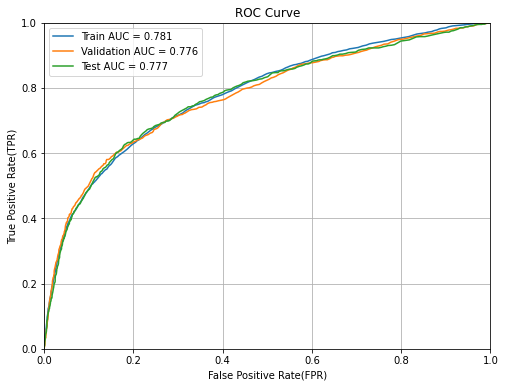

In [62]:
plt.figure(figsize=(8,6))
plt.plot(x[0],x[1],label=f'Train AUC = {np.round(xgb_best.model_performance(train=True).auc(),3)}')
plt.plot(y[0],y[1],label=f'Validation AUC = {np.round(xgb_best.model_performance(valid=True).auc(),3)}')
plt.plot(z[0],z[1],label=f'Test AUC = {np.round(xgb_best.model_performance(test_data = test_frame).auc(),3)}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid()

## 3. Simulating a test set with recession conditions

We'll now alter the existing test set to represent some adverse scenarios, like recession. For that we'll start by creating a copy of the test set

In [49]:
# Creating a copy of the dataset
data_recession = test.copy(deep=True)
data_recession.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,7,500000,1,4.0,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
2,11,200000,2,3.0,3,2,34,0,0,2,0,0,-1,11073,9787,5535,2513,1828,3731,2306,12,50,300,3738,66,0
3,20,180000,2,3.0,1,2,29,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27,60000,1,2.0,1,2,27,1,-2,-1,-1,-1,-1,-109,-425,259,-57,127,-189,0,1000,0,500,0,1000,1




Next we would alter some of the feature values of the test set so that it can mimic a dataset that would be seen incase of a recession.Some notable aspects of a recession are unemployments, negative economic growth, loan and mortgage defaults, decreased credit limits for customers, increased consumer debt etc. 

### 1. Change payments to be more late 
We start by delaying the payments which is typical in such a scenario.

In [50]:
payments = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
data_recession[payments] += 3


### 2. Change payments to be more lower

Next, we'll decreasing the payments of the customers by 1000 NT dollars each.

In [51]:
pay_amounts = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
data_recession[pay_amounts] -= 1000 


### 3. Decrease the credit limits 
Let's also decrease the credit limits of every customer again by 1000 NT dollars each


In [52]:
data_recession['LIMIT_BAL'] -= 1000



### 4. Increase Bill Amounts
Lastly, we'll add 500 NT dollars to all Bill Amounts thereby increasing the bill amounts to be paid by each customer.

In [53]:
bill_amounts = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
data_recession[bill_amounts] -=500


### 5. Randomly upsample the customers who will default on the payment

Also, in a recession condition, there'll be a higher probability of customers to default on the payment. To take that into account, we'll also randomly increase the number of customers with DEFAULT_NEXT_MONTH=1

In [54]:
sample=data_recession.sample(frac=0.05,random_state=SEED) #Sampling random data points
sample['DEFAULT_NEXT_MONTH'] = 1
data_recession.update(sample)
update_list = sample.index.tolist()

In [55]:
data_recession['DEFAULT_NEXT_MONTH'].value_counts()

0.0    3748
1.0    1288
Name: DEFAULT_NEXT_MONTH, dtype: int64

## 4. Re-evaluating performance on the simulated recession test set
Now that we have simulated a dataset that in a way mimics some sort of adverse condition that our model might  encounter in the real world, it is time to looks at the performance metrics on this data.

In [56]:

# Converting Pandas dataframe into H2O Frame
test_frame_recession = h2o.H2OFrame(data_recession)

# Setting target column to factor so we can build classification model

test_frame_recession[target] = test_frame_recession[target].asfactor()

In [57]:
perf_test = xgb_best.model_performance(test_data=test_frame_recession)
perf_test.auc()

0.612159818569904

## 5. Plotting ROC curves for training, validation and simulated test dataset after Stress testing

In [58]:
perf_train = xgb_best.model_performance(train=True)
perf_valid = xgb_best.model_performance(valid=True)
perf_simulated_test = xgb_best.model_performance(test_data=test_frame_recession)



x = perf_train.plot(type = 'roc',plot=False);
y = perf_valid.plot(type = 'roc',plot=False);
z = perf_simulated_test.plot(type = 'roc',plot=False);

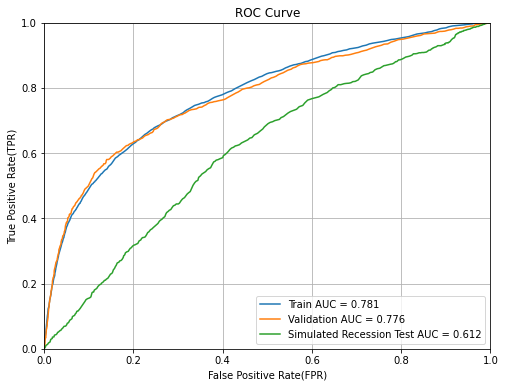

In [59]:
plt.figure(figsize=(8,6))
plt.plot(x[0],x[1],label=f'Train AUC = {np.round(xgb_best.model_performance(train=True).auc(),3)}')
plt.plot(y[0],y[1],label=f'Validation AUC = {np.round(xgb_best.model_performance(valid=True).auc(),3)}')
plt.plot(z[0],z[1],label=f'Simulated Recession Test AUC = {np.round(xgb_best.model_performance(test_data=test_frame_recession).auc(),3)}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.grid()

Shutdown H2O Cluster

In [ ]:
h2o.cluster().shutdown(prompt=True)